In [3]:
import os
import json
from langchain_openai import ChatOpenAI
from langchain.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
)
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import (
    JsonOutputParser,
)
from langchain.tools import (
    Tool,
)
from langchain.chains import LLMMathChain
from langchain.agents import create_openai_functions_agent, AgentExecutor
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.graph import END, START, StateGraph
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from typing import TypedDict, Optional, List, Tuple, Literal, Dict
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from IPython.display import Image, display


In [4]:
# Load environment variables from the .env file
load_dotenv("../config/dev.env")
OPENAPI_KEY = os.getenv("OPENAI_API_KEY")
llm = ChatOpenAI(api_key=OPENAPI_KEY, model="gpt-4o", temperature=0.0)
#llm.invoke("heelo")

--------------------
Node: initial_question_answers
Initial state: {'grade': '12', 'question_history': ['A car travels 150 miles in 3 hours. If the car continues at the same speed, how far will it travel in 5 hours?'], 'math_subject': 'algebra'}
Generated question: A train travels 240 miles in 4 hours. If the train continues at the same speed, how far will it travel in 7 hours?
Generated answers: ['420 miles', '480 miles', '560 miles', '600 miles']
Message history length: 1
--------------------
Node: review_question
Current state: {'grade': '12', 'question_history': ['A car travels 150 miles in 3 hours. If the car continues at the same speed, how far will it travel in 5 hours?'], 'math_subject': 'algebra', 'initial_question': 'A train travels 240 miles in 4 hours. If the train continues at the same speed, how far will it travel in 7 hours?', 'initial_possible_answers': ['420 miles', '480 miles', '560 miles', '600 miles'], 'final_question': None, 'final_possible_answers': None, 'final_c

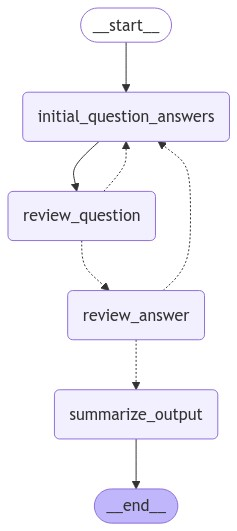

In [8]:
import os
import json
from typing import List
from typing import TypedDict, Optional, List, Dict, Literal
from langchain_openai import ChatOpenAI
from langchain.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
)
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import (
    JsonOutputParser,
)
from langchain.tools import (
    Tool,
)
from langchain.chains import LLMMathChain
from langchain.agents import create_openai_functions_agent, AgentExecutor
from langchain.prompts import PromptTemplate
from langgraph.graph import END, START, StateGraph


class MathProblem(BaseModel):
    problem_name: str = Field(
        description="A math word problem with all the information needed to solve it"
    )
    hints: list = Field(description="hints to solve the math problem")
    multiple_choice: list = Field(description="A list of four multiple choice answers")
    answer: str = Field(description="The multiple choice answer to the math problem")


def get_question_template():
    template = """You are a math teacher for {grade} grade. Your job is to provide a worded math problem according to this {math_concept}. Do not ask a question is similar to previous questions {question_history}.
    RULES: ALL THE DETAILS TO SOLVE THE PROBLEM MUST BE INCLUDED IN THE PROBLEM NAME."""
    return template


# step 2 generate a question
#@genai.post("/ai_chat_agent_get_question/")
def ai_chat_agent_get_question(query: dict) -> dict:
    """Get a math word problem question based on Grade, Topic."""
    OPENAPI_KEY = os.getenv("OPENAI_API_KEY")
    llm = ChatOpenAI(api_key=OPENAPI_KEY, model="gpt-4o", temperature=0.0)
    question_history = query["question_history"]

    user_dict = query["user_dict"]
    try:
        user_dict = json.loads(user_dict)
    except:
        user_dict = user_dict
    grade = user_dict["grade"]
    try:
        question_history = json.loads(question_history)
    except:
        question_history = question_history
    math_info_dict = query["math_info"]
    try:
        math_info_dict = json.loads(math_info_dict)
    except:
        math_info_dict = math_info_dict
    concept_name = math_info_dict["concept_name"]

    math_problem_template = get_question_template()
    math_problem_filled_in = math_problem_template.format(
        **{
            "grade": grade,
            "math_concept": concept_name,
            "question_history": question_history,
        }
    )

    structured_llm = llm.with_structured_output(MathProblem)
    response = structured_llm.invoke(math_problem_filled_in)
    response_dict = response.dict()

    output_dict = {
        "retrieval_response": response_dict,
    }
    return output_dict


def validate_question_with_langgraph(question_answers_dict: dict):
    OPENAPI_KEY = os.getenv("OPENAI_API_KEY")
    llm = ChatOpenAI(api_key=OPENAPI_KEY, model="gpt-4o", temperature=0.0)
    #question = "there were 10 apples in a basket. 5 apples were taken out. How many apples are left in the basket?"
    #possible_answers = ["5", "10", "15", "0"]

    try:
        question = question_answers_dict["retrieval_response"]["problem_name"]
    except:
        question = question_answers_dict["problem_name"]
    try:
        possible_answers = question_answers_dict["retrieval_response"]["multiple_choice"]
    except:
        possible_answers = question_answers_dict["multiple_choice"]

    word_problem_template = """You are a teacher developing exam questions for students. 
    You have this question {question} that you want to ask your students and these four possible answers {possible_answers}.
    You need to validate that each possible answer and return if the answer is correct or incorrect."""

    llm_math = LLMMathChain.from_llm(llm=llm)

    word_problem_tool = Tool(
        name="MathReasoningTool",
        func=llm_math.run,
        description="A tool that helps you solve logic-based questions",
    )
    tools = [word_problem_tool]
    llm_with_tools = llm.bind_tools(tools=tools)

    class MathQuestion(BaseModel):
        answer_1: bool = Field(description="Is the first answer correct?")
        answer_2: bool = Field(description="Is the second answer correct?")
        answer_3: bool = Field(description="Is the third answer correct?")
        answer_4: bool = Field(description="Is the fourth answer correct?")

    prompt = word_problem_template.format(
        question=question, possible_answers=possible_answers
    )
    # rsp = llm_with_tools.invoke([prompt])
    rsp = llm_with_tools.with_structured_output(MathQuestion).invoke([prompt])
    # Convert to dictionary
    validation_results = {
        'answer_1': rsp.answer_1,
        'answer_2': rsp.answer_2,
        'answer_3': rsp.answer_3,
        'answer_4': rsp.answer_4
    }
    
    # Validate that at least one answer is correct
    if not any(validation_results.values()):
        print("Warning: No correct answers found in validation")
        
    return validation_results

MAX_REVISIONS = 5


class GraphState(TypedDict):
    grade: Optional[str]
    question_history: Optional[List[str]]
    math_subject: Optional[str]
    initial_question: Optional[str]
    initial_possible_answers: Optional[List[str]]
    final_question: Optional[str]
    final_possible_answers: Optional[List[str]]
    final_correct_answer: Optional[str]
    ai_confirmation_question: Optional[bool]
    ai_confirmation_answer: Optional[bool]
    revision_count: Optional[int]
    message_history: Optional[List[str]]


def initial_question_answers(state: GraphState) -> GraphState:
    print("--------------------")
    print("Node: initial_question_answers")
    print(f"Initial state: {state}")
    
    question_dict = {
        "user_dict": {"grade": state["grade"]}, 
        "question_history": state["question_history"], 
        "math_info": {"concept_name": state["math_subject"]}
    }

    try:
        question_rsp = ai_chat_agent_get_question(question_dict)
        initial_question = question_rsp['retrieval_response']['problem_name']
        initial_possible_answers = question_rsp['retrieval_response']['multiple_choice']
    except Exception as e:
        print(f"Error generating question: {e}")
        raise

    # Initialize all state fields
    state["initial_question"] = initial_question
    state["initial_possible_answers"] = initial_possible_answers
    state["final_question"] = None
    state["final_possible_answers"] = None
    state["final_correct_answer"] = None
    state["ai_confirmation_question"] = None
    state["ai_confirmation_answer"] = None
    state["revision_count"] = 0
    
    # Initialize or update message history
    if state.get("message_history") is None:
        state["message_history"] = []
    
    # Add initial question generation to history
    state["message_history"].append(
        f"Generated Question: {initial_question}\n" + 
        f"Generated Answers: {initial_possible_answers}"
    )
    
    print(f"Generated question: {initial_question}")
    print(f"Generated answers: {initial_possible_answers}")
    print(f"Message history length: {len(state['message_history'])}")
    return state


def review_question(state: GraphState) -> GraphState:
    print("--------------------")
    print("Node: review_question")
    print(f"Current state: {state}")
    
    OPENAPI_KEY = os.getenv("OPENAI_API_KEY")
    llm = ChatOpenAI(api_key=OPENAPI_KEY, model="gpt-4", temperature=0.0)
    
    if state["revision_count"] >= MAX_REVISIONS:
        print("Max revisions reached")
        state["ai_confirmation_question"] = False
        state["message_history"].append("Maximum revision limit reached. Moving to final output.")
        return state

    class ValidQuestion(BaseModel):
        valid_question: bool = Field(description="Does the question provide enough information to solve the problem?")
        feedback: str = Field(description="Specific feedback about why the question is valid or invalid")

    # Include message history in the prompt
    history_text = "\n".join(state["message_history"]) if state["message_history"] else "No previous history"
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a math teacher reviewing questions for clarity and completeness."),
        ("human", """Previous attempts and feedback:
{history}

Current question to review: {question}

Does this question provide all necessary information to solve the problem? 
If not, explain what's missing or unclear.""")
    ])
    
    chain = prompt | llm.with_structured_output(ValidQuestion)
    response = chain.invoke({
        "question": state["initial_question"],
        "history": history_text
    })
    
    state["ai_confirmation_question"] = response.valid_question
    state["message_history"].append(
        f"Question Review:\n" +
        f"Valid: {response.valid_question}\n" +
        f"Feedback: {response.feedback}"
    )
    
    if response.valid_question:
        state["final_question"] = state["initial_question"]
    else:
        state["revision_count"] += 1
    
    print(f"Question validation result: {response.valid_question}")
    print(f"Feedback: {response.feedback}")
    print(f"Revision count: {state['revision_count']}")
    return state

def review_question_decision(state: GraphState) -> Literal["review_answer", "initial_question_answers"]:
    """Determine next node based on question validation result."""
    print("\n--------------------")
    print("Decision: review_question_decision")
    
    if state["ai_confirmation_question"]:
        print("Decision: Question valid -> proceeding to review answer")
        return "review_answer"
    else:
        print("Decision: Question invalid -> generating new question")
        return "initial_question_answers"
    

def review_answer(state: GraphState) -> GraphState:
    print("--------------------")
    print("Node: review_answer")
    print(f"Current state: {state}")
    
    try:
        question = state["initial_question"]
        possible_answers = state["initial_possible_answers"]
        
        # Include message history in validation context
        history_text = "\n".join(state["message_history"]) if state["message_history"] else "No previous history"
        
        question_answers_dict = {
            "problem_name": question,
            "multiple_choice": possible_answers,
            "history": history_text
        }
        
        validation_dict = validate_question_with_langgraph(question_answers_dict)
        print('validation from math agent', validation_dict)
        
        for idx, (answer_key, is_correct) in enumerate(validation_dict.items(), 1):
            if is_correct:
                state["ai_confirmation_answer"] = True
                state["final_possible_answers"] = state["initial_possible_answers"]
                state["final_correct_answer"] = state["initial_possible_answers"][idx-1]
                if not state["final_question"]:
                    state["final_question"] = state["initial_question"]
                
                state["message_history"].append(
                    f"Answer validation successful:\n" +
                    f"Correct answer found: {state['final_correct_answer']}"
                )
                print(f"Found correct answer: {state['final_correct_answer']}")
                break
        
        if not state.get("ai_confirmation_answer"):
            print("No correct answer found")
            state["revision_count"] = state.get("revision_count", 0) + 1
            state["message_history"].append(
                "No correct answer found in current options. Requesting revision."
            )
            
    except Exception as e:
        error_msg = f"Error validating answer: {e}"
        print(error_msg)
        state["revision_count"] = state.get("revision_count", 0) + 1
        state["ai_confirmation_answer"] = False
        state["message_history"].append(error_msg)
        
    return state



def review_answer_decision(state: GraphState) -> Literal["summarize_output", "initial_question_answers"]:
    """Determine next node based on answer validation result."""
    print("\n--------------------")
    print("Decision: review_answer_decision")
    
    if state["ai_confirmation_answer"]:
        print("Decision: Answer valid -> proceeding to summarize")
        return "summarize_output"
    else:
        print("Decision: Answer invalid -> returning to revise question and answers")
        return "initial_question_answers"

def summarize_output(state: GraphState) -> Dict:
    print("--------------------")
    print("Node: summarize_output")
    print(f"Final state: {state}")
    
    final_question = state.get("final_question") or state.get("initial_question")
    final_possible_answers = state.get("final_possible_answers") or state.get("initial_possible_answers")
    
    # Add final summary to message history
    state["message_history"].append(
        f"Final Output:\n" +
        f"Question: {final_question}\n" +
        f"Answers: {final_possible_answers}\n" +
        f"Correct Answer: {state.get('final_correct_answer')}\n" +
        f"Total Revisions: {state.get('revision_count', 0)}"
    )
    
    return {
        "final_question": final_question,
        "final_possible_answers": final_possible_answers,
        "final_correct_answer": state.get("final_correct_answer"),
        "revision_count": state.get("revision_count", 0),
        "initial_question": state.get("initial_question"),
        "initial_possible_answers": state.get("initial_possible_answers"),
        "ai_confirmation_question": state.get("ai_confirmation_question"),
        "ai_confirmation_answer": state.get("ai_confirmation_answer"),
        "grade": state.get("grade"),
        "math_subject": state.get("math_subject"),
        "message_history": state.get("message_history", [])
    }
def create_workflow():
    """Create and configure the workflow with proper state handling."""
    workflow = StateGraph(GraphState)

    # Add nodes
    workflow.add_node("initial_question_answers", initial_question_answers)
    workflow.add_node("review_question", review_question)
    workflow.add_node("review_answer", review_answer)
    workflow.add_node("summarize_output", summarize_output)
    
    # Set entry point
    workflow.set_entry_point("initial_question_answers")

    # Define the primary flow
    workflow.add_edge("initial_question_answers", "review_question")
    
    # Add conditional edges for question review
    workflow.add_conditional_edges(
        source="review_question",
        path=review_question_decision,
        path_map={
            "initial_question_answers": "initial_question_answers",
            "review_answer": "review_answer",  
        },
    )
    
    # Add conditional edges for answer review
    workflow.add_conditional_edges(
        source="review_answer",
        path=review_answer_decision,
        path_map={
            "summarize_output": "summarize_output",
            "initial_question_answers": "initial_question_answers",  
        },
    )

    # Add final edge
    workflow.add_edge("summarize_output", END)

    return workflow.compile()

def main():
    app = create_workflow()
    question_dict = {"user_dict": {"grade": "12"}, "math_info": {"concept_name": "algebra"}, "question_history": ["A car travels 150 miles in 3 hours. If the car continues at the same speed, how far will it travel in 5 hours?"]}

    result = app.invoke(
        {
            "grade": question_dict["user_dict"]["grade"],
            "question_history": question_dict["question_history"],
            "math_subject": question_dict["math_info"]["concept_name"],
        }
    )
    print("-------")
    for k, v in result.items():
        print(f"{k}: {v}")
    display(
        Image(
            app.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.API,
            )
        )
    )

if __name__ == "__main__":
    main()